In [13]:
import os
import cv2
import json
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from pathlib import Path

In [14]:
def calc_back_btw_hair_row(examie_row, hair_seg_label=17):
    hair_loc = np.where(examie_row == 17)[0]
    if len(hair_loc) == 0:
        return -1
    start, end = hair_loc[0], hair_loc[-1]
    length_hair = end - start + 1
    hair_mask = examie_row[start: end+1].copy()
    hair_mask[hair_mask != hair_seg_label] = 0
    hair = np.count_nonzero(hair_mask)
    return 1 - hair / length_hair

define consts

In [19]:
label_root_dir = '/data3/khs_labels/'
dataset_json_path = '/data2/chence/PanoHeadData/single_view_hq/dataset-cam-filtered.json'
passed_model_dir = '/data3/khs_check'
exception_features = [
    "묶음머리",
    "넘긴머리",
    "악성곱슬머리",
    "땋은머리",
    "기타악세사리",
    "기타"
]
check_hairlength = [
    "장발",
    "중발"
]

passed_model_ids = [Path(_).stem for _ in os.listdir(passed_model_dir)]

Load present dataset meta

In [23]:
print(f'Loading present dataset meta from: {dataset_json_path}', end='...', flush=True)
with open(dataset_json_path, 'r') as f:
    dataset = json.load(f)
print(f'Done.')
print(f'Length of dataset: {len(dataset)}')

Loading present dataset meta from: /data2/chence/PanoHeadData/single_view_hq/dataset-cam-filtered.json...Done.
Length of dataset: 279637


In [27]:
# get datasource
other_kept_img_names = []
khs_delete = []
khs_keep = []
check_samples = {}
print(f'Filtering KHS data...')
pbar = tqdm.tqdm(total=len(dataset))
for image_name, image_meta in dataset.items():
    pbar.update()
    source = image_meta['data_source']
    if not(source.startswith('K-Hairstyle')): # we keep all other data
        other_kept_img_names.append(image_name)
        continue
    path_label = 'validation_labels' if source == 'K-Hairstyle/Validation' else 'training_labels'
    new_path = image_meta['align_image_path'].replace('align_images', path_label)
    new_path = new_path.replace('._00.png', '.json') if new_path.endswith('._00.png') else new_path.replace('_00.png', '.json')
    new_path = new_path.replace('-', '_')
    abs_path = os.path.join(label_root_dir, new_path)
    if not(os.path.exists(abs_path)):
        print(f'Warning: {abs_path} does not exist.')
        continue
    pbar.set_description(f'Processing {os.path.basename(new_path)}')
    # acquire the original json
    with open(abs_path, 'r') as f:
        label = json.load(f)
        exceptional = label['exceptional']
        hairlength = label['length']
        if exceptional in exception_features:
            khs_delete.append(image_name) # need to delete this image with execption attributes
            continue
        if hairlength in check_hairlength:
            model_id = os.path.basename(os.path.dirname(new_path))
            if not(model_id in passed_model_ids):
                khs_delete.append(image_name)
                continue
        khs_keep.append(image_name)

In [28]:
print(len(khs_keep))
print(len(khs_delete))
print(len(other_kept_img_names))
# with open('./temp/check_khs.json', 'w') as f:
#     json.dump(check_samples, f, indent=4)

33231
15196
231210


In [36]:
all_keeps = khs_keep + other_kept_img_names
print(len(all_keeps))
sorted_all_keeps = sorted(all_keeps, key=lambda x: (int(x.split('/')[0]), int(x.split('/')[1][3:-4])))
save_json_path = '/data2/chence/PanoHeadData/single_view_hq/dataset_v2.json'
output_dict = {}
for img_name in sorted_all_keeps:
    output_dict[img_name] = dataset[img_name]
with open(save_json_path, 'w') as f:
    json.dump(output_dict, f, indent=4)

264441


In [21]:
def crop_bottom(img, crop_begin=1, crop_width=100):
    return img[-crop_begin - crop_width: -crop_begin, :]


def calc_ratio_non_headback(examine_par, return_image=False):
    examine_par[examine_par == 17] = 0
    examine_size = examine_par.shape[0] * examine_par.shape[1]
    non_headback = np.count_nonzero(examine_par)
    ratio_non_headback = non_headback / examine_size
    if return_image:
        return ratio_non_headback, examine_par
    return ratio_non_headback


def calc_back_btw_hair_row(examie_row, hair_seg_label=17):
    hair_loc = np.where(examie_row == 17)[0]
    if len(hair_loc) == 0:
        return -1
    start, end = hair_loc[0], hair_loc[-1]
    length_hair = end - start + 1
    hair_mask = examie_row[start: end+1].copy()
    hair_mask[hair_mask != hair_seg_label] = 0
    hair = np.count_nonzero(hair_mask)
    return 1 - hair / length_hair


test = np.array([[0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 0],
                 [0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 0, 1]])
result = np.apply_along_axis(calc_back_btw_hair_row, 1, test)
print(np.max(result))

-1


In [11]:
import shutil

parsing_root_dir = '/data2/chence/PanoHeadData/single_view_hq/align_parsing'
image_root_dir   = parsing_root_dir.replace('align_parsing', 'align_images')

saved_json_dir = '/home/shitianhao/project/DatProc/temp/check_khs.json'
copied_path = '/data3/khs_check'
os.makedirs(copied_path, exist_ok=True)
with open(saved_json_dir, 'r') as f:
    check_samples = json.load(f)
    
for model_id in tqdm.tqdm(check_samples.keys()):
    for seg_name in check_samples[model_id]:
        assert seg_name in dataset.keys(), f'{seg_name} does not exist in dataset'
        img_view = dataset[seg_name]["view"]
        if img_view != 'back': continue
        img_abs_path = os.path.join(image_root_dir, seg_name.replace('png', 'jpg'))
        assert os.path.exists(img_abs_path), f'{img_abs_path} does not exist'
        img_save_path = os.path.join(copied_path, f'{model_id}.jpg')
        shutil.copy(img_abs_path, img_save_path)



  0%|          | 0/1421 [00:00<?, ?it/s]

100%|██████████| 1421/1421 [02:54<00:00,  8.15it/s]


In [ ]:
parsing_root_dir = '/data2/chence/PanoHeadData/single_view_hq/align_parsing'
image_root_dir   = parsing_root_dir.replace('align_parsing', 'align_images')
good_ratios = {
    'max': [], 
    'min': [],
    'avg': []
}
bad_ratios = {
    'max': [], 
    'min': [],
    'avg': []
}
idk_ratios = {
    'max': [], 
    'min': [],
    'avg': []
}
for _type in ['idk']:
    curr_dict = bad_ratios if _type == 'bad' else idk_ratios
    for model_id in check_samples.keys():
        for seg_name in check_samples[model_id]:
            # image = image.replace('png', 'jpg')
            seg_abs_path = os.path.join(parsing_root_dir, seg_name)
            img_abs_path = os.path.join(image_root_dir, seg_name.replace('png', 'jpg'))
            assert os.path.exists(seg_abs_path), f'{seg_abs_path} does not exist'
            assert os.path.exists(img_abs_path), f'{img_abs_path} does not exist'
            img = cv2.imread(img_abs_path)
            seg = cv2.imread(seg_abs_path, cv2.IMREAD_GRAYSCALE)
            seg_cropped = crop_bottom(seg)
            img_cropped = crop_bottom(img)
            ratio = np.apply_along_axis(calc_back_btw_hair_row, 1, seg_cropped)
            ratio = ratio[ratio>=0]
            try:
                curr_max, curr_min, curr_avg = np.max(ratio), np.min(ratio), np.average(ratio)
                curr_dict['max'].append(curr_max)
                curr_dict['min'].append(curr_min)
                curr_dict['avg'].append(curr_avg)
                print(f'ratio: max={curr_max}, min={curr_min}, avg={curr_avg}')
                fig, ax = plt.subplots(1, 3, figsize=(5, 15))
                # add title
                ax[0].imshow(seg)       
                ax[1].imshow(img)
                ax[2].imshow(seg_cropped)
                ax[0].set_xticklabels([])
                ax[0].set_yticklabels([])
                ax[1].set_xticklabels([])
                ax[1].set_yticklabels([])
                ax[2].set_xticklabels([])
                ax[2].set_yticklabels([])
                plt.show()
            except:
                pass
        break
    fig, axs = plt.subplots(3, 1)
    axs = axs.flatten()
    for idx, key in enumerate(['max', 'min', 'avg']):
        axs[idx].hist(idk_ratios[key], bins=20, color='blue', alpha=0.5)
        # axs[idx].hist(bad_ratios[key], bins=20, color='red', alpha=0.5)
        axs[idx].set_title(key)

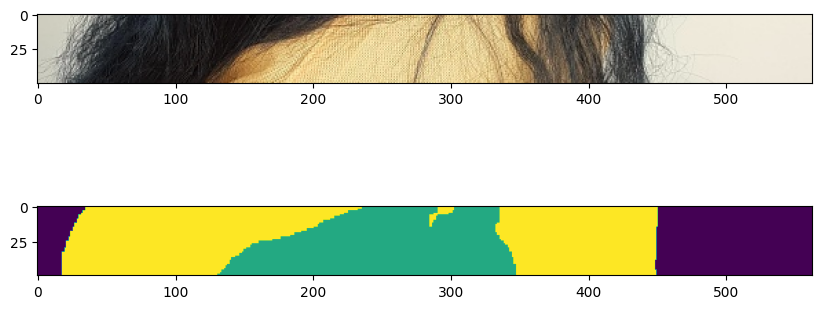

In [28]:
sample_seg_path = '/data2/chence/PanoHeadData/multi_view_hq/align_parsing/00087/img00000000.png'
sample_img_path = sample_seg_path.replace('align_parsing', 'align_images').replace('png', 'jpg')
img = cv2.imread(sample_img_path)
seg = cv2.imread(sample_seg_path, cv2.IMREAD_GRAYSCALE)
examine_width = 50 #px
examine_seg = seg[-examine_width:, :]
examine_img = img[-examine_width:, :]
labels, counts = np.unique(examine_seg, return_counts=True)
# generate random colors
colors = np.random.randint(0, 255, size=(len(labels)))
# create the segmented image
segmented_image = np.zeros_like(examine_seg)
# color each label
for label, color in zip(labels, colors):
    segmented_image[examine_seg == label] = color
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].imshow(examine_img)
ax[1].imshow(segmented_image)
plt.subplots_adjust(hspace=0)
plt.show()


